In [1]:
#importing libraries
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir,path
import PIL
import cv2
import numpy
import string
from pickle import dump, load
import random
from numpy import array
from numpy import argmax
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical,plot_model,model_to_dot
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout,SimpleRNN, Conv2D, MaxPooling2D,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from IPython.display import Image
from nltk.translate.bleu_score import corpus_bleu
from tqdm.notebook import tqdm
from glob import glob
from nltk.translate.bleu_score import sentence_bleu

In [2]:
#directories 
imagePath = 'flickr8k/Images/'

captionDatasetPath = 'flickr8k/captions.txt'

images = glob(imagePath+'*.jpg')

len(images)


8091

# Text Preprocessing

In [3]:
#loading captions
def loadingCaptions(filePath):
    
    preCleanedCaptionDict = {}


    for caption in open(filePath):
        #splitting the caption 
        #print(caption)
        token = caption.split()

        if(len(token)<2):
            continue
        #splitting in to image id and caption
        imageId,captionText = token[0].split('.')[0],token[1:]

        #converting caption text into string
        captionText = ' '.join(captionText)

        #saving into dictonary
        if(imageId not in preCleanedCaptionDict):
            preCleanedCaptionDict[imageId] = [captionText]
        else:
            preCleanedCaptionDict[imageId].append(captionText)
            
    return preCleanedCaptionDict
    

preCleanedCaptionDict = loadingCaptions(captionDatasetPath)


    
len(preCleanedCaptionDict)
    



8091

In [4]:
#getting 5 random images
uni_filenames=[]
for _ in range(5):
    
    file = random.choice(images).split('\\')[-1]
    uni_filenames.append(file)
uni_filenames

['2949014128_0d96196261.jpg',
 '1501811302_5e723fc529.jpg',
 '2978394277_4572967b97.jpg',
 '3405942945_f4af2934a6.jpg',
 '2030781555_b7ff7be28f.jpg']

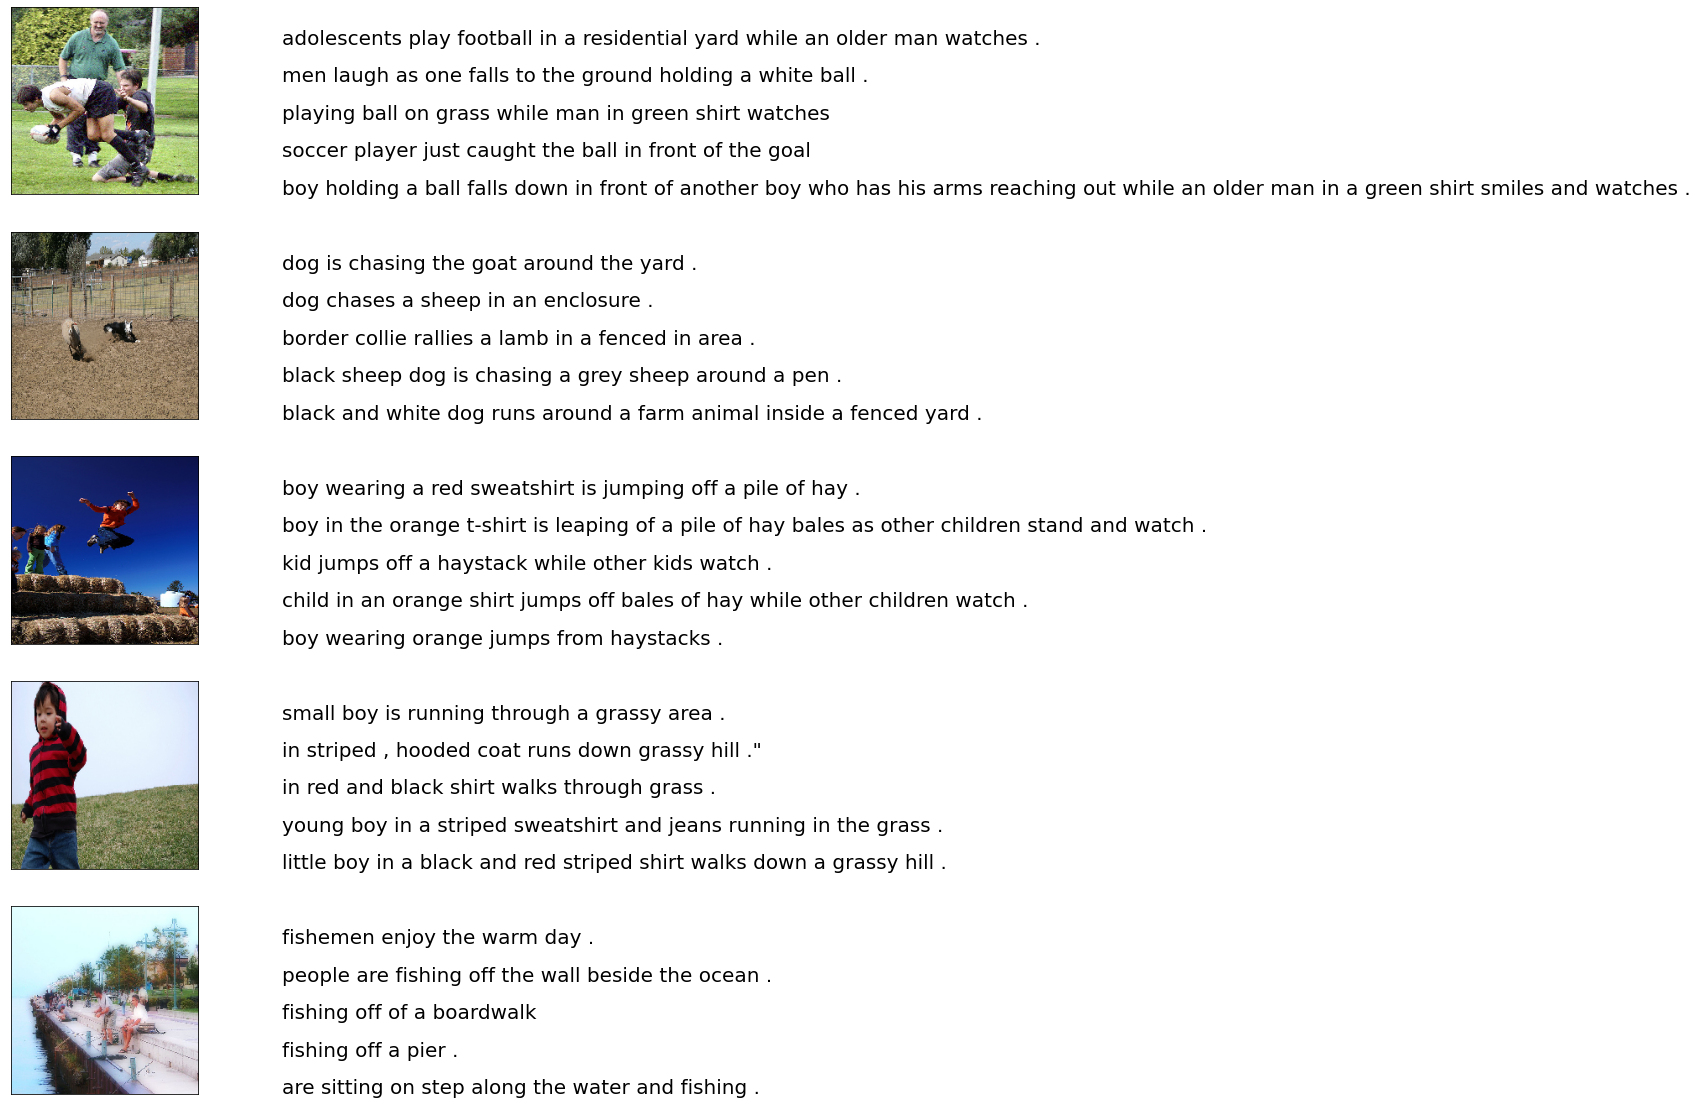

In [5]:
#plotting image and caption
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames:
    
        filename = imagePath + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        capList=[]

        key = jpgfnm.split('.')[0]

        for caption in preCleanedCaptionDict[key]:

            capList.append(caption)
                
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(capList))
        for i, caption in enumerate(capList):
            ax.text(0,i,caption,fontsize=20)
        count += 1
plt.show()

In [6]:
#cleaning the caption
def cleanCaption(preCleanedCaptionDict):
    
    captionDict = {}
    table = str.maketrans('', '', string.punctuation) #table of removing the punctuation


    for captionId, caption in preCleanedCaptionDict.items():
        
        for i in range(len(caption)):
            
            captionDesc = caption[i]
            captionDesc = captionDesc.split()
            
            # Converting all the words to lower case
            captionDesc = [token.lower() for token in captionDesc]
            
            # Removing the punctuation 
            captionDesc = [token.translate(table) for token in captionDesc]  ## re.sub(r'[^a-zA-Z0-9'], '', captionDesc)
            
            # Removing the words with length =1
            captionDesc = [token for token in captionDesc if len(token)>1]
            
            # Removing all the numerical characters
            captionDesc = [token for token in captionDesc if token.isalpha()]
            
            # concatinating startseq and endseq so the model would know when to end the traiing
            caption[i] = 'startseq ' + ' '.join(captionDesc) + ' endseq'
            
        captionDict[captionId] = caption
            
    return captionDict

captionDict={}
captionDict = cleanCaption(preCleanedCaptionDict)
        
        
        

In [7]:
captionDict['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [8]:
#appending all captions in new list
captionList=[]

for key in captionDict:
    
    for caption in captionDict[key]:
        
        captionList.append(caption)
    
    

In [9]:
len(captionList)

40453

In [10]:
captionList[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq dogs of different breeds looking at each other on the road endseq',
 'startseq dogs on pavement moving toward each other endseq']

In [11]:
#tokenizing all the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captionList)
vocabSize = len(tokenizer.word_index) + 1

vocabSize

8683

In [12]:
# get maximum length of the caption
maxLength = max(len(caption.split()) for caption in captionList)
maxLength

33

# Extracting the features

In [19]:
#Extracting features
def extractVggFeatures(directory):
    # load the model
    model = VGG16()
    
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    
    print(model.summary())
    
    # extract features from each photo
    features = dict()
    
    for name in listdir(directory):
        
        
        filename = directory + '/' + name
        
        #loading the image from file
        image = load_img(filename, target_size=(224, 224))
        
        #converting image to array
        image = img_to_array(image)
        
        #reshape data for model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        #preprocessing for model
        image = preprocess_input(image)
        
        #extract feature 
        feature = model.predict(image, verbose=0)
        
        #getting image id
        imageId = name.split('.')[0]
     
        features[imageId] = feature
        

        

    return features

In [20]:


extractedVggFeatures = extractVggFeatures(imagePath)

print('Extracted Features: ', len(extractedVggFeatures))

# Dumping the features in a pickle file for further use
dump(extractedVggFeatures, open('vggFeatures.pkl', 'wb'))





Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:

with open('vggFeatures.pkl', 'rb') as f:
    extractedVggFeatures = load(f)
    
print('Extracted Features: ', len(extractedVggFeatures))

Extracted Features:  8091


In [44]:
#Extracting features
def extractAlexNetFeatures(directory):
    # Alexnet architecture
    
    model = Sequential()
    
    model.add(Conv2D(filters=96,kernel_size=(3,3),strides=(4,4),input_shape=(224, 224, 3), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(256,(5,5),padding='same',activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
    
    model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
    
    model.add(Conv2D(256,(3,3),padding='same',activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

    model.add(Flatten())
    
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(4096,activation='softmax'))
    
    
    # extract features from each photo
    features = dict()
    
    for name in listdir(directory):
        
        
        filename = directory + '/' + name
        
        #loading the image from file
        image = load_img(filename, target_size=(224, 224))
        

        #converting image to array
        image = img_to_array(image)
        
        #reshape data for model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        #preprocessing for model
        image = preprocess_input(image)
        
        #extract feature 
        feature = model.predict(image, verbose=0)
        
        #getting image id
        imageId = name.split('.')[0]
     
        features[imageId] = feature
        

        

    return features

In [ ]:
extractedAlexNetFeatures = extractAlexNetFeatures(imagePath)

print('Extracted Features: ', len(extractedAlexNetFeatures))

# Dumping the features in a pickle file for further use
dump(extractedAlexNetFeatures, open('AlexnetFeatures.pkl', 'wb'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 56, 56, 96)        2688      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 384)       885120    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 384)       1327488   
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 256)      

In [14]:

with open('alexNetFeatures.pkl', 'rb') as f:
    extractedAlexNetFeatures = load(f)
    
print('Extracted Features: ', len(extractedAlexNetFeatures))

Extracted Features:  8091


# Train test split

In [15]:
imageIds = list(captionDict.keys())
#splitting 90 percentage train data and 10 percentage test data
data = int(len(imageIds) * 0.90)
train = imageIds[:data]
test = imageIds[data:]
print("training length: ",len(train))
print("testing length: ",len(test))

training length:  7281
testing length:  810


In [16]:

#create a batch worth of data for a single photo rather than an entire dataset. 
def generator(imagIds, captionDict, extractedFeatures, tokenizer, maxLength, vocabSize, batchSize):
    
    X1, X2, y = list(),list(),list()

    n = 0

    while 1: 

        for key in imageIds:

            n += 1

            captions = captionDict[key]

            #getting each caption
            for caption in captions:
                
                # for each word there will be assigned sequence
                seq = tokenizer.texts_to_sequences([caption])[0]


                for i in range(1, len(seq)):
                    # split into input and output pair
                    inSeq, outSeq = seq[:i], seq[i]

                    # pad input sequence
                    inSeq = pad_sequences([inSeq], maxlen=maxLength)[0]

                    # encode output sequence
                    outSeq = to_categorical([outSeq], num_classes=vocabSize)[0]

                    # store the sequences
                    X1.append(extractedFeatures[key][0])
                    X2.append(inSeq)
                    y.append(outSeq)

            if n == batch_size:
                    #converting into array
                    X1, X2, y = np.array(X1), np.array(X2), np.array(y)

                    yield [X1, X2], y

                    X1, X2, y = list(), list(), list()

                    n = 0
        
         
            
          
        
    

In [17]:
def defineModel(vocabLength,maxLength):
    #layers for image
    input1= Input(shape=(4096,))
    droplayer = Dropout(0.5)(input1)
    denselayer = Dense(256, activation='relu')(droplayer)

    #layers for text
    input2 = Input(shape=(maxLength,))
    embedding = Embedding(vocabLength, 256, mask_zero=True)(input2)
    droplayer_ = Dropout(0.5)(embedding)
    rnn = SimpleRNN(256)(droplayer_)

    #decoding
    decoder1 = add([denselayer, rnn])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocabLength, activation='softmax')(decoder2)


    model = Model(inputs=[input1, input2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')


    print(model.summary())
    
    return model

In [24]:
vggModel = defineModel(vocabSize, maxLength)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 256)      2222848     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [25]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    modelGenerator = generator(train, captionDict, extractedVggFeatures, tokenizer, maxLength, vocabSize, batch_size)
    # fitting model
    vggModel.fit(modelGenerator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 310s 1s/step - loss: 2.3077


In [ ]:
# saving the model with last parameter 
vggModel.save('./vggModel.h5')

In [18]:
alexNetModel = defineModel(vocabSize, maxLength)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 256)      2222848     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_1[0][0]                    
______________________________________________________________________________________________

In [19]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    modelGenerator = generator(train, captionDict, extractedAlexNetFeatures, tokenizer, maxLength, vocabSize, batch_size)
    # fitting model
    alexNetModel.fit(modelGenerator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 236s 1s/step - loss: 2.9851


In [21]:
# saving the model with last parameter 
alexNetModel.save('./alexNetModel.h5')

# Model prediction and evaluation

In [17]:
#converting word into tokenizer
def indexToWord(number, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == number:
            return word
    return None

In [18]:
# predicting caption
def predictCaption(model, image, tokenizer, maxLength):
    # add startseq for test image
    Text = 'startseq'
    # iterate over the max length of sequence
    for i in range(maxLength):
        # for each word there will be assigned sequence
        sequence = tokenizer.texts_to_sequences([Text])[0]
        # pad input sequence
        sequence = pad_sequences([sequence], maxLength)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = indexToWord(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        Text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return Text

In [25]:
#prediction for test image
actual, predicted = list(), list()
vggModel = load_model('./vggModel.h5')

for key in tqdm(test):
    #get actual caption
    captions = captionDict[key]
    #predict the caption for image
    prediction = predictCaption(vggModel, extractedVggFeatures[key], tokenizer, maxLength) 
    #split into words
    actualCaptions = [caption.split() for caption in captions]
    prediction = prediction.split()
    #append to the list
    actual.append(actualCaptions)
    predicted.append(prediction)
    
#calcuating BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.537504
BLEU-2: 0.316597
BLEU-3: 0.228275
BLEU-4: 0.116245


In [19]:
#Extracting features
def extractVggTestFeatures(filename):
    # load the model
    model = VGG16()
    
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    
    
    # extract features from each photo
    features = dict()
        
    #loading the image from file
    image = load_img(filename, target_size=(224, 224))
        
    #converting image to array
    image = img_to_array(image)
        
    #reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
    #preprocessing for model
    image = preprocess_input(image)
        
    #extract feature 
    feature = model.predict(image, verbose=0)
        
    #getting image id
    imageId = filename.split('.')[0]
     
    features[imageId] = feature
    
    return features

In [20]:
def generateVggCaption(imageName):
    # load the image
    vggModel = load_model('./vggModel.h5')
    extractedVggTestFeatures = extractVggTestFeatures(imageName)
    imageId = imageName.split('.')[0]
    image = PIL.Image.open(imageName)
    # predict the caption
    y_pred = predictCaption(vggModel, extractedVggTestFeatures[imageId], tokenizer, maxLength)
    print()
    print('Predicted:')
    print()
    print(y_pred)
    plt.imshow(image)


Predicted:

startseq black dog with red collar running in field endseq


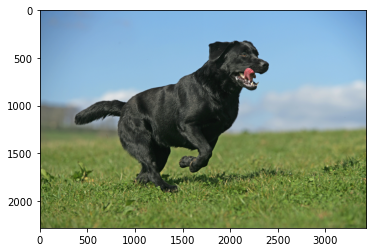

In [21]:
generateVggCaption("black-lab-favorite-dog-main-220315-e8e0ee.jpg")

In [34]:
#prediction for test image
actual, predicted = list(), list()
alexNetModel = load_model('./alexNetModel.h5')

for key in tqdm(test):
    #get actual caption
    captions = captionDict[key]
    #predict the caption for image
    prediction = predictCaption(alexNetModel, extractedAlexNetFeatures[key], tokenizer, maxLength) 
    #split into words
    actualCaptions = [caption.split() for caption in captions]
    prediction = prediction.split()
    #append to the list
    actual.append(actualCaptions)
    predicted.append(prediction)
    
#calcuating BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.479169
BLEU-2: 0.193660
BLEU-3: 0.115326
BLEU-4: 0.041112


In [25]:
#Extracting features
def extractAlexNetTestFeatures(filename):
    # Alexnet architecture
    
    model = Sequential()
    
    model.add(Conv2D(filters=96,kernel_size=(3,3),strides=(4,4),input_shape=(224, 224, 3), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(256,(5,5),padding='same',activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
    
    model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
    
    model.add(Conv2D(256,(3,3),padding='same',activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

    model.add(Flatten())
    
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(4096,activation='softmax'))
    
    
    # extract features from each photo
    features = dict()
    
        
    #loading the image from file
    image = load_img(filename, target_size=(224, 224))
        

    #converting image to array
    image = img_to_array(image)
        
    #reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
    #preprocessing for model
    image = preprocess_input(image)
        
    #extract feature 
    feature = model.predict(image, verbose=0)
        
    #getting image id
    imageId = filename.split('.')[0]
     
    features[imageId] = feature
        

        

    return features

In [26]:
def generateAlexNetCaption(imageName):
    # load the image
    alexNetModel = load_model('./alexNetModel.h5')
    extractedAlexNetTestFeatures = extractAlexNetTestFeatures(imageName)
    imageId = imageName.split('.')[0]
    image = PIL.Image.open(imageName)
    # predict the caption
    y_pred = predictCaption(alexNetModel, extractedAlexNetTestFeatures[imageId], tokenizer, maxLength)
    print()
    print('Predicted:')
    print()
    print(y_pred)
    plt.imshow(image)


Predicted:

startseq dog is running through the water endseq


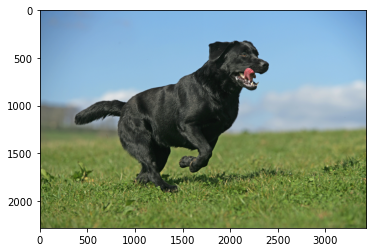

In [27]:
generateAlexNetCaption("black-lab-favorite-dog-main-220315-e8e0ee.jpg")